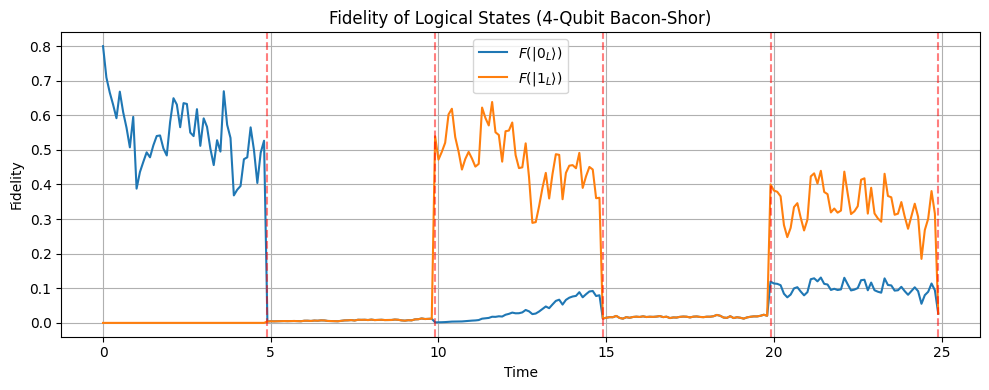

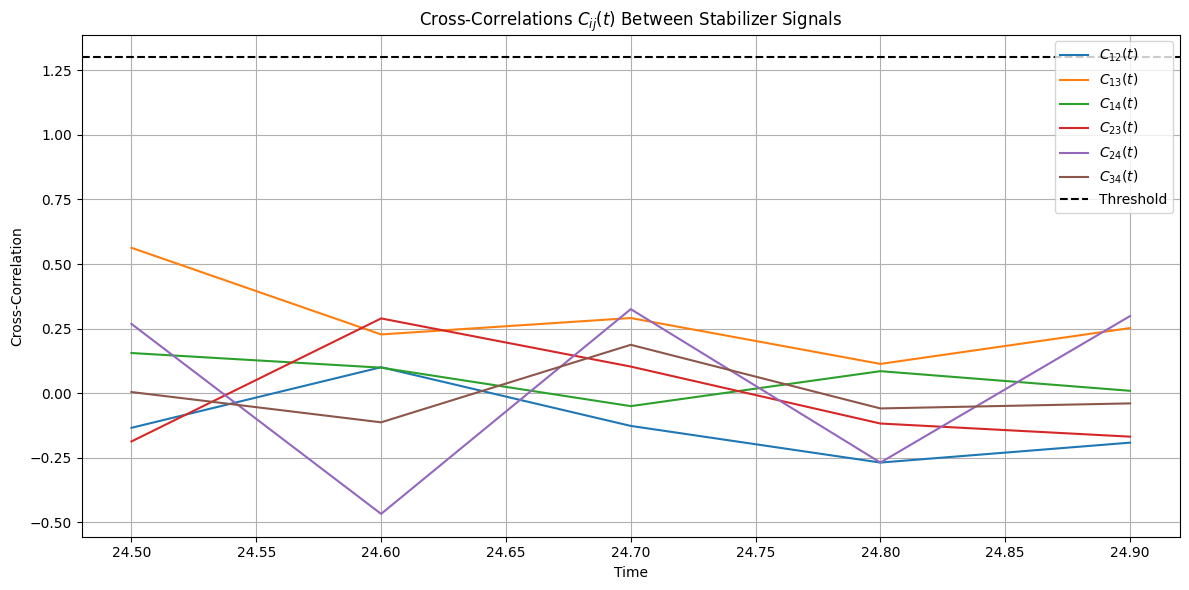

Detected errors: [('X1', np.float64(4.9)), ('X3', np.float64(9.9)), ('X1', np.float64(14.9)), ('X1', np.float64(19.900000000000002)), ('X3', np.float64(24.900000000000002))]


In [84]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Parameters
gamma_m = 1.0
Omega_0 = 0.1 * gamma_m
sigma = 2
top = 25 / gamma_m
gamma = 1e-3 * gamma_m
eta = 1
tau = 5 / gamma_m
dt = 0.1
N = 4
threshold_corr = 1.3
tlist = np.arange(0, top, dt)
window_size = int(tau / dt)

I, X, Z = qeye(2), sigmax(), sigmaz()
omega_t = lambda t: Omega_0 * np.exp(-0.5 * ((t - top / 2) / sigma) ** 2)
delta_t = lambda t: 2 * Omega_0 * (t / (top / 2) - 1)

def op_on_qubit(op, i):
    return tensor([op if k == i else I for k in range(N)])

X_ops = [op_on_qubit(X, i) for i in range(N)]
Z_ops = [op_on_qubit(Z, i) for i in range(N)]

# Gauge operators
S1 = X_ops[0] * X_ops[1]
S2 = Z_ops[0] * Z_ops[2]
S3 = X_ops[2] * X_ops[3]
S4 = Z_ops[1] * Z_ops[3]
gauge_ops = [S1, S2, S3, S4]

X_L_1 = X_ops[0] * X_ops[2]
Z_L_1 = Z_ops[0] * Z_ops[1]

# Collapse operators
c_ops = [np.sqrt(gamma) * X_ops[i] for i in range(N)]

# Initial state: logical |0_L⟩ = (|0000⟩ + |1111⟩)/√2
psi0 = (tensor([basis(2, 0)] * 4) + tensor([basis(2, 1)] * 4)).unit()
rho = ket2dm(psi0)

# Logical basis
zero = psi0
one = X_L_1 * psi0

# Buffers for raw signals
windows = [deque(maxlen=window_size) for _ in range(4)]

# Result trackers
cross_correlators = { (i,j): [] for i in range(4) for j in range(i+1, 4) }
fidelities_0, fidelities_1 = [], []
errors = []

# Main loop
for ti, t in enumerate(tlist):
    H = X_L_1 * omega_t(t) + Z_L_1 * delta_t(t)
    dW = np.random.normal(scale=np.sqrt(dt), size=4)
    
    meas = [
        np.sqrt(2 * gamma_m * eta) * (S * rho + rho * S - 2 * expect(S, rho) * rho)
        for S in gauge_ops
    ]

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    for s in gauge_ops:
        drho += gamma_m * (s * rho * s - 0.5 * (s**2 * rho + rho * s**2))
    drho += sum(m * dw for m, dw in zip(meas, dW))
    rho = (rho + dt * drho).unit()

    # Noisy signals
    I_raw = [expect(S, rho) + dw / np.sqrt(dt) for S, dw in zip(gauge_ops, dW)]
    
    # Update signal windows
    for i in range(4):
        windows[i].append(I_raw[i])

    if all(len(w) == window_size for w in windows):
        I_bars = [np.mean(w) for w in windows]

        # Cross-correlators C_ij = mean of I_i * I_j
        for i in range(4):
            for j in range(i+1, 4):
                corr = np.mean([a * b for a, b in zip(windows[i], windows[j])])
                cross_correlators[(i,j)].append(corr)

        # Error detection: use C13 and C24
        C13 = cross_correlators[(0,2)][-1]
        C24 = cross_correlators[(1,3)][-1]
        I1_bar, I2_bar, I3_bar, I4_bar = I_bars

        if C13 < threshold_corr:
            if I1_bar < 0:
                rho = X_ops[0] * rho * X_ops[0]
                errors.append(("X1", t))
            elif I3_bar < 0:
                rho = X_ops[1] * rho * X_ops[1]
                errors.append(("X2", t))
            for w in windows: w.clear()

        if C24 < threshold_corr:
            if I2_bar < 0:
                rho = X_ops[2] * rho * X_ops[2]
                errors.append(("X3", t))
            elif I4_bar < 0:
                rho = X_ops[3] * rho * X_ops[3]
                errors.append(("X4", t))
            for w in windows: w.clear()

    # Fidelity tracking
    fidelities_0.append((zero.dag() * rho * zero))
    fidelities_1.append((one.dag() * rho * one))

# --- Plot Fidelity ---
plt.figure(figsize=(10, 4))
plt.plot(tlist, fidelities_0, label=r"$F(|0_L\rangle)$")
plt.plot(tlist, fidelities_1, label=r"$F(|1_L\rangle)$")
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity of Logical States (4-Qubit Bacon-Shor)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot All Cross-Correlators ---
plt.figure(figsize=(12, 6))
for (i, j), values in cross_correlators.items():
    time_x = tlist[-len(values):]  # align time with buffer length
    plt.plot(time_x, values, label=fr"$C_{{{i+1}{j+1}}}(t)$")
plt.axhline(threshold_corr, color='black', linestyle='--', label="Threshold")
plt.xlabel("Time")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlations $C_{ij}(t)$ Between Stabilizer Signals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Detected errors:", errors)


ValueError: x and y must have same first dimension, but have shapes (5000,) and (200,)

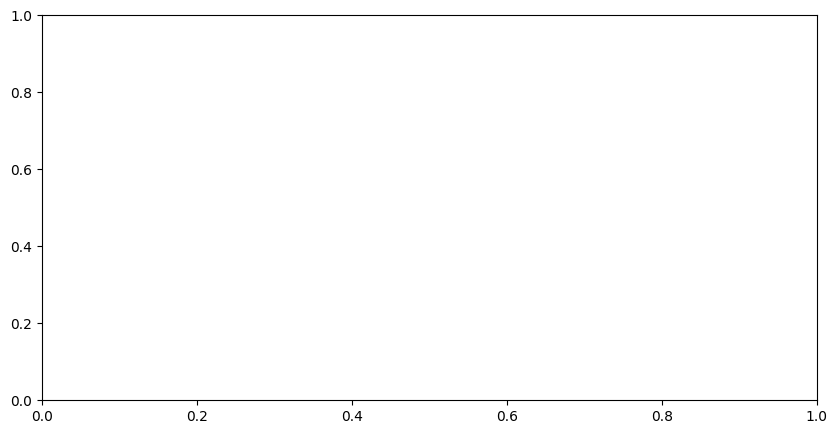

In [70]:
# Plotting cross-correlations C13 and C24
plt.figure(figsize=(10, 5))
plt.plot(tlist, C13_vals, label=r'$C_{13}(t)$', color='purple')
plt.plot(tlist, C24_vals, label=r'$C_{24}(t)$', color='orange')
plt.axhline(threshold_corr, color='red', linestyle='--', label='Threshold')
plt.xlabel("Time")
plt.ylabel("Cross-correlation")
plt.title("Cross-correlations $C_{13}(t)$ and $C_{24}(t)$ for Error Detection")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Initial state: logical |0_L> = |000>
rho = ket2dm(psi0)

# Record fidelity
fidelities_0_no_meas = []
fidelities_1_no_meas = []

# Time evolution loop
for t in tlist:
    H = (X_L_1)*omega_t(t) + (Z_L_1)*delta_t(t)

    drho = -1j * (H * rho - rho * H)
    for c in c_ops:
        drho += c * rho * c.dag() - 0.5 * (c.dag() * c * rho + rho * c.dag() * c)
    
    rho = (rho + dt * drho).unit()

    fidelities_0_no_meas.append((zero.dag() * rho * zero))
    fidelities_1_no_meas.append((one.dag() * rho * one))

[]


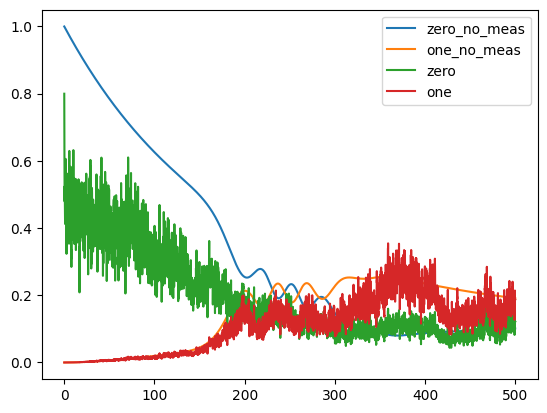

In [25]:
# Plot infidelity
# infidelities = [1 - f for f in fidelities_0]
print(errors)
plt.plot(tlist, fidelities_0_no_meas, label='zero_no_meas')
plt.plot(tlist, fidelities_1_no_meas, label='one_no_meas')
plt.plot(tlist, fidelities_0, label='zero')
plt.plot(tlist, fidelities_1, label='one')
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
plt.legend()

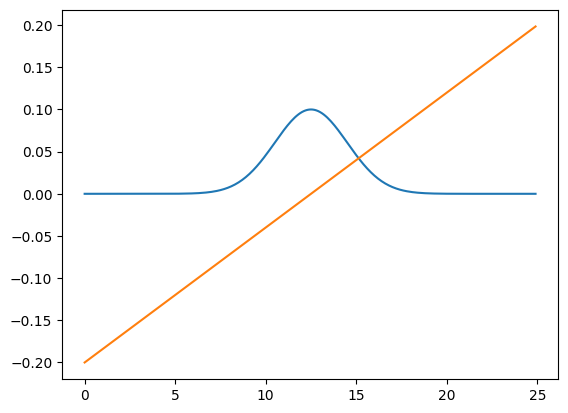

In [83]:
plt.plot(tlist, omega_t(tlist))
plt.plot(tlist, delta_t(tlist))
plt.show()

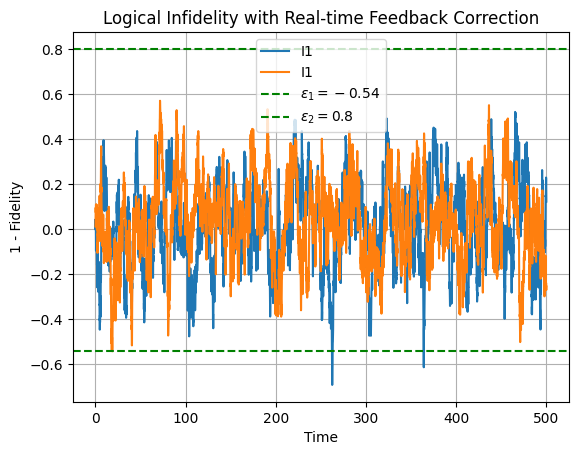

In [18]:
plt.plot(tlist, I1s, label='I1')
plt.plot(tlist, I2s, label='I1')
plt.axhline(threshold_high, color='green', linestyle='--', label=r'$\epsilon_1 = -0.54$')
plt.axhline(threshold_low, color='green', linestyle='--', label=r'$\epsilon_2 = 0.8$')
for e in errors:
    plt.axvline(x=e[1], color='red', linestyle='--', label=e[0])  # Add this line
    
# plt.yscale('log')
# plt.xlim([290, 320])
plt.xlabel('Time')
plt.ylabel('1 - Fidelity')
plt.title('Logical Infidelity with Real-time Feedback Correction')
plt.grid(True)
plt.legend()
plt.show()